# Titanic — Decision Tree

This notebook will:

1. Load `train.csv`, data preprocessing；
2. Use GridSearchCV to finetune hyperparameters of DecisionTreeClassifier；
3. Visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [21]:
# read training data
df = pd.read_csv('train.csv')
print('shape:', df.shape)
df.head()

shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
# Simple preprocessing and feature engineering
data = df.copy()
# New feature: whether Cabin info exists
data['HasCabin'] = data['Cabin'].notna().astype(int)
# Fill missing Age with median, Fare with median, Embarked with mode
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
# New features: FamilySize and IsAlone
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
# Drop unnecessary columns
data = data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
# One-hot encode categorical variables (Sex, Embarked)
data = pd.get_dummies(data, columns=['Sex','Embarked'], drop_first=True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,2,0,True,False,True
1,1,1,38.0,1,0,71.2833,1,2,0,False,False,False
2,1,3,26.0,0,0,7.9250,0,1,1,False,False,True
3,1,1,35.0,1,0,53.1000,1,2,0,False,False,True
4,0,3,35.0,0,0,8.0500,0,1,1,True,False,True


In [23]:
# Select features and split the dataset
features = ['Pclass','Age','SibSp','Parch','Fare','HasCabin','FamilySize','IsAlone','Sex_male','Embarked_Q','Embarked_S']
X = data[features]
y = data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('train shape:', X_train.shape, 'val shape:', X_val.shape)

train shape: (712, 11) val shape: (179, 11)


In [24]:
# Use GridSearchCV to tune Decision Tree hyperparameters
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5,6,8,10, None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}
grid = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid.fit(X_train, y_train)
print('best score (cv):', grid.best_score_)
print('best params:', grid.best_params_)

best score (cv): 0.816113464000788
best params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10}


val accuracy: 0.7988826815642458

Classification report:

              precision    recall  f1-score   support

           0       0.78      0.95      0.85       110
           1       0.87      0.57      0.68        69

    accuracy                           0.80       179
   macro avg       0.82      0.76      0.77       179
weighted avg       0.81      0.80      0.79       179



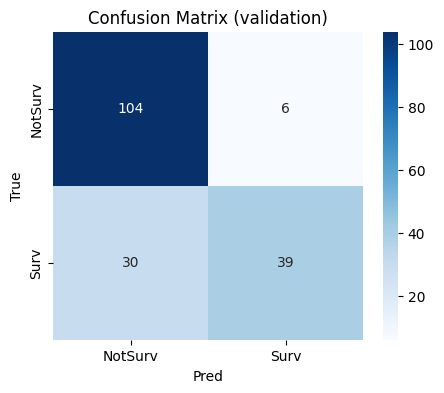

In [25]:
# Evaluate the best model on the validation set
best = grid.best_estimator_
y_pred = best.predict(X_val)
print('val accuracy:', accuracy_score(y_val, y_pred))
print('\nClassification report:\n')
print(classification_report(y_val, y_pred))
# Confusion matrix visualization
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NotSurv','Surv'], yticklabels=['NotSurv','Surv'])
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion Matrix (validation)')
plt.show()

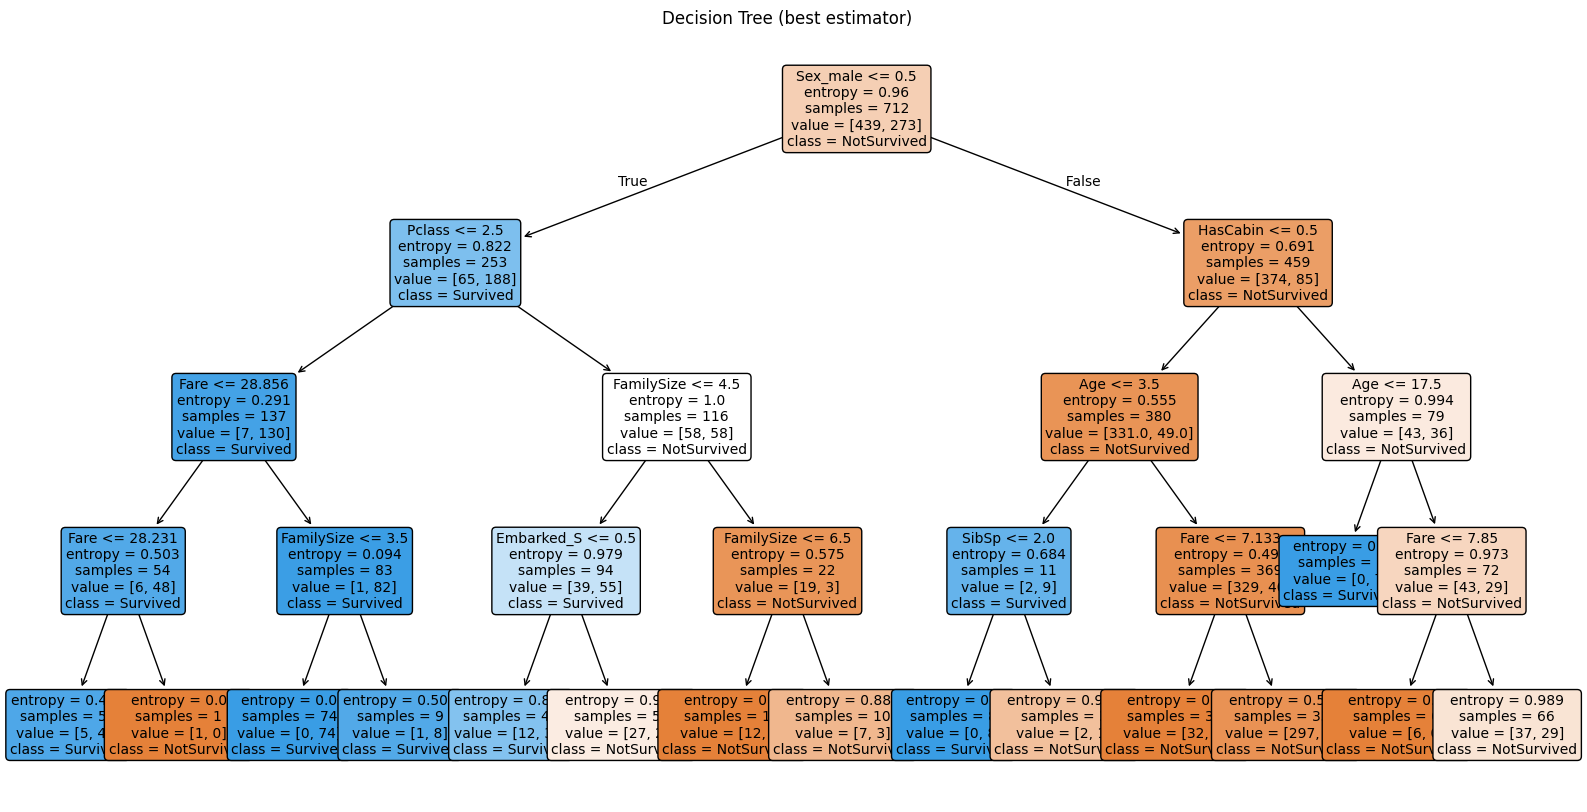

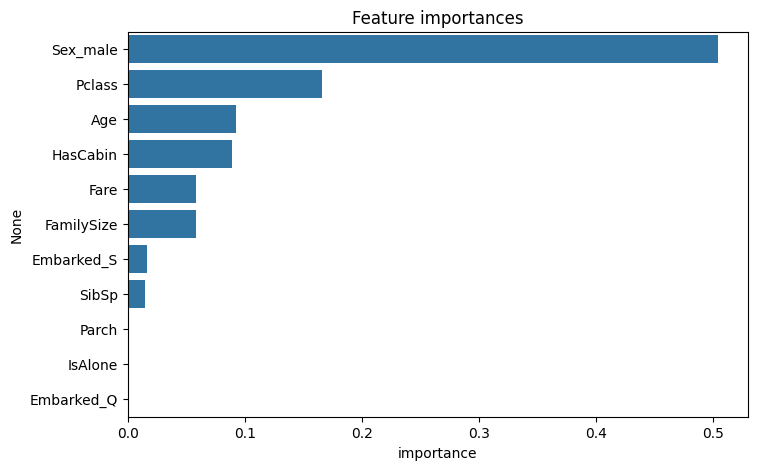

Sex_male      0.504192
Pclass        0.165719
Age           0.092379
HasCabin      0.089120
Fare          0.058680
FamilySize    0.058646
Embarked_S    0.016097
SibSp         0.015168
Parch         0.000000
IsAlone       0.000000
Embarked_Q    0.000000
dtype: float64

In [26]:
plt.figure(figsize=(20,10))
plot_tree(best, feature_names=features, class_names=['NotSurvived','Survived'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree (best estimator)')
plt.show()


fi = pd.Series(best.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=fi.values, y=fi.index)
plt.title('Feature importances')
plt.xlabel('importance')
plt.show()
fi

## Implement five fold cross validation

In [28]:
cv_scores = cross_val_score(grid.best_estimator_, X, y, cv=5, scoring='accuracy', n_jobs=1)
print('5-fold CV accuracies:', cv_scores)
print('Mean accuracy: {:.4f} +/- {:.4f}'.format(cv_scores.mean(), cv_scores.std()))

5-fold CV accuracies: [0.76536313 0.8258427  0.79775281 0.78089888 0.85393258]
Mean accuracy: 0.8048 +/- 0.0317


## Random Forest

In [ ]:
# Random Forest: GridSearchCV and evaluation
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None,5,10],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=1)
rf_grid.fit(X_train, y_train)
print('RF best score (cv):', rf_grid.best_score_)
print('RF best params:', rf_grid.best_params_)
# Evaluate on validation set
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_val)
print('RF val accuracy:', accuracy_score(y_val, y_pred_rf))
print('









rf_fiplt.show()plt.xlabel('importance')plt.title('RF Feature importances')sns.barplot(x=rf_fi.values, y=rf_fi.index)plt.figure(figsize=(8,5))rf_fi = pd.Series(rf_best.feature_importances_, index=features).sort_values(ascending=False)# Feature importancesprint(classification_report(y_val, y_pred_rf))RF Classification report:
')